## Setup
This notebook follows largely https://www.tensorflow.org/beta/tutorials/load_data/images with a few modifications.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install -q tensorflow_datasets
!pip install -q tensorflow==2.0.0-beta0
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Download and inspect the dataset

In [2]:
#Retrieve the images
import pathlib
data_root = pathlib.Path('./images/')

In [3]:
for item in data_root.iterdir():
  print(item)

images/non_vulnerable
images/vulnerable


In [4]:
import random
all_image_paths = list(data_root.glob('*/*.jpg'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

2868

### Inspect the images
Now let's have a quick look at a couple of the images, so we know what we're dealing with:

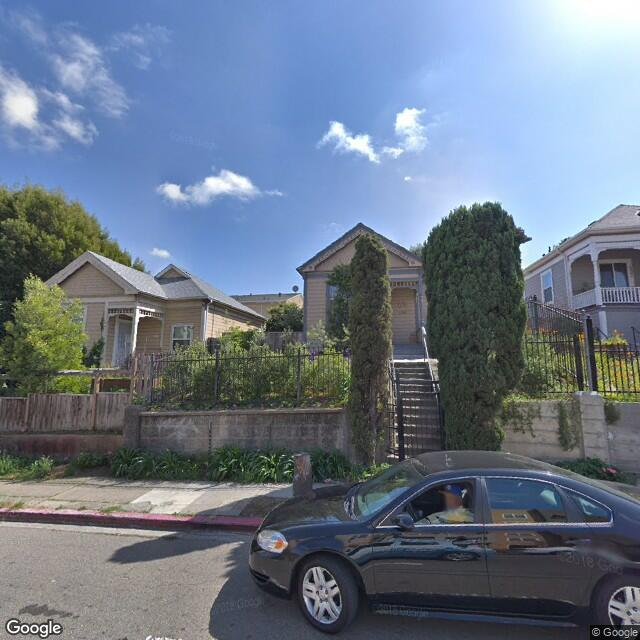

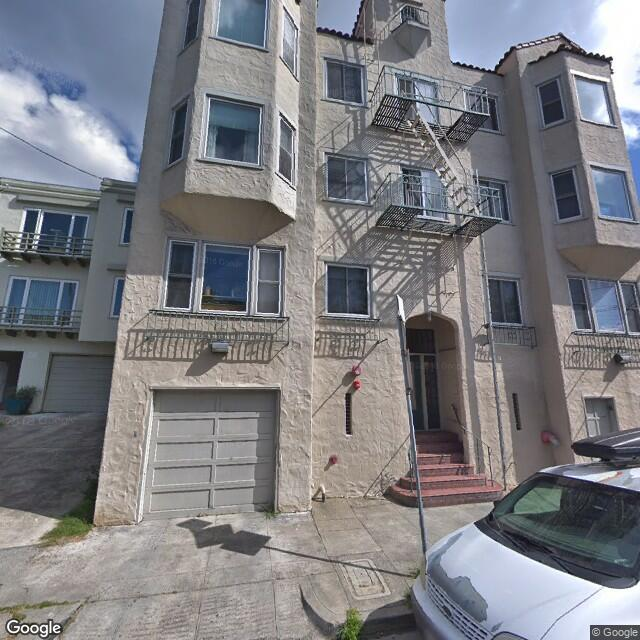

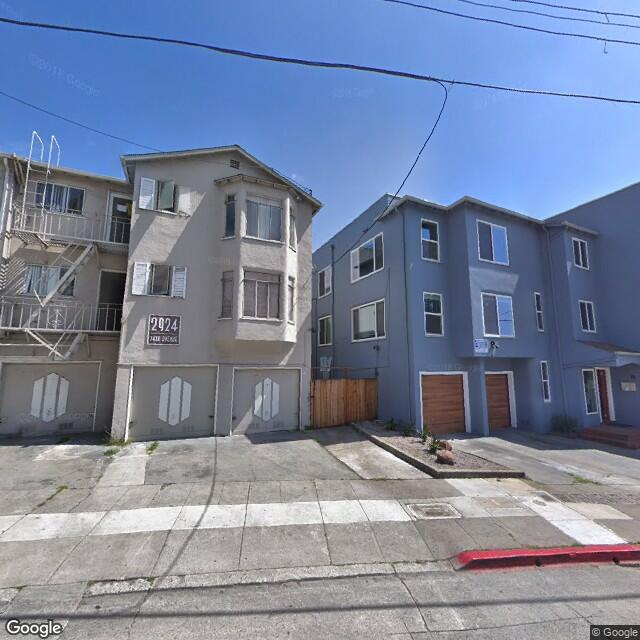

In [5]:
import os
import IPython.display as display

for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path,width=200))
    print()

### Determine the label for each image

List the available labels:

In [6]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['non_vulnerable', 'vulnerable']

Assign an index to each label:

In [7]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'non_vulnerable': 0, 'vulnerable': 1}

Create a list of every file, and its label index

In [8]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [0, 1, 1, 1, 1, 0, 1, 1, 0, 1]


### Load and format the images

TensorFlow includes all the tools you need to load and process images:

In [9]:
img_path = all_image_paths[0]
img_path

'images/non_vulnerable/view_non_vulnerable_1560406485_+37.811771_-122.214663_10_4818+PARK+BL+OAKLAND+3+94602.jpg'

here is the raw data:

In [10]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


Decode it into an image tensor:

In [11]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(640, 640, 3)
<dtype: 'uint8'>


Resize it for your model:

In [12]:
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())


(192, 192, 3)
0.0
1.0


Wrap up these up in simple functions for later.

In [13]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range
    return image

In [14]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [15]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.title(label_names[label].title())
print()

## Build a `tf.data.Dataset`

### A dataset of images

The easiest way to build a `tf.data.Dataset` is using the `from_tensor_slices` method.

Slicing the array of strings, results in a dataset of strings:

In [16]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

The `shapes` and `types` describe the content of each item in the dataset. In this case it is a set of scalar binary-strings

Now create a new dataset that loads and formats images on the fly by mapping `preprocess_image` over the dataset of paths.

In [17]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

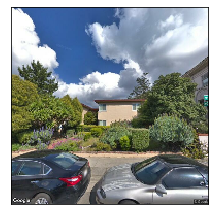

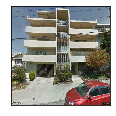

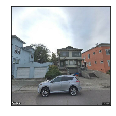

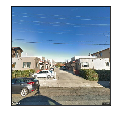

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

### A dataset of `(image, label)` pairs

Using the same `from_tensor_slices` method we can build a dataset of labels

In [19]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [20]:
for label in label_ds.take(3):
    print(label_names[label.numpy()])

non_vulnerable
vulnerable
vulnerable


Since the datasets are in the same order we can just zip them together to get a dataset of `(image, label)` pairs.

In [21]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

The new dataset's `shapes` and `types` are tuples of shapes and types as well, describing each field:

In [22]:
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


Note: When you have arrays like `all_image_labels` and `all_image_paths` an alternative to `tf.data.dataset.Dataset.zip` is to slice the pair of arrays.

In [23]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* To repeat forever.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [24]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

There are a few things to note here:

1. The order is important.

  * A `.shuffle` after a `.repeat` would shuffle items across epoch boundaries (some items will be seen twice before others are seen at all).
  * A `.shuffle` after a `.batch` would shuffle the order of the batches, but not shuffle the items across batches.

1. We use a `buffer_size` the same size as the dataset for a full shuffle. Up to the dataset size, large values provide better randomization, but use more memory.

1. The shuffle buffer is filled before any elements are pulled from it. So a large `buffer_size` may cause a delay when your `Dataset` is starting.

1. The shuffeled dataset doesn't report the end of a dataset until the shuffle-buffer is completely empty. The `Dataset` is restarted by `.repeat`, causing another wait for the shuffle-buffer to be filled.

This last point can be addressed by using the `tf.data.Dataset.apply` method with the fused `tf.data.experimental.shuffle_and_repeat` function:

In [25]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

W0613 23:29:04.421619 140650835646272 deprecation.py:323] From <ipython-input-25-4dc713bd4d84>:2: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

### Pipe the dataset to a model

Fetch a copy of Inception v3 from `tf.keras.applications`.

This will be used for a simple transfer learning example.

Set the Inception v3 weights to be non-trainable:

In [26]:
inception = tf.keras.applications.InceptionV3(input_shape=(192, 192, 3), include_top=False)
inception.trainable=False

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(inception.layers))

##Fine tune from this layer onwards
# fine_tune_at = 295

##Freeze all the layers before the `fine_tune_at` layer
# for layer in inception.layers[:fine_tune_at]:
#   layer.trainable =  False

Number of layers in the base model:  311


This model expects its input to be normalized to the `[-1,1]` range:

```
help(keras_applications.inceptionv3.preprocess_input)
```

<pre>
...
This function applies the "Inception" preprocessing which converts
the RGB values from [0, 255] to [-1, 1]
...
</pre>

So before the passing it to the MobilNet model, we need to convert the input from a range of `[0,1]` to `[-1,1]`.

In [27]:
def change_range(image,label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

The Inceptionv3 returns a `6x6` spatial grid of features for each image.

Pass it a batch of images to see:

In [28]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))

In [29]:
feature_map_batch = inception(image_batch)
print(feature_map_batch.shape)

(32, 4, 4, 2048)


So build a model wrapped around MobileNet, and use `tf.keras.layers.GlobalAveragePooling2D` to average over those space dimensions, before the output `tf.keras.layers.Dense` layer:

In [30]:
model = tf.keras.Sequential([
  inception,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

Now it produces outputs of the expected shape:

In [31]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: -1.8571335
max logit: 3.3313217

Shape: (32, 2)


Compile the model to describe the training procedure:

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

There are 2 trainable variables: the Dense `weights` and `bias`:

In [33]:
len(model.trainable_variables)

2

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 4, 4, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


Train the model.

Normally you would specify the real number of steps per epoch, but for demonstration purposes only run 3 steps.

In [35]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

90.0

In [36]:
ds = image_label_ds.cache()
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [37]:
model.fit(ds, epochs=5, steps_per_epoch=90)

Epoch 1/5


W0613 23:29:33.861260 140650835646272 deprecation.py:323] From /home/muehlemann/Dropbox/eq/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


90/90 [==============================] - 86s 956ms/step - loss: 5.6010 - accuracy: 0.6476
Epoch 2/5
90/90 [==============================] - 82s 914ms/step - loss: 5.6412 - accuracy: 0.6500
Epoch 3/5
90/90 [==============================] - 75s 836ms/step - loss: 2.0941 - accuracy: 0.4667
Epoch 4/5
90/90 [==============================] - 75s 833ms/step - loss: 0.6931 - accuracy: 0.3483
Epoch 5/5
90/90 [==============================] - 75s 833ms/step - loss: 0.6931 - accuracy: 0.3500


In [38]:
prediction=model.predict(image_batch.numpy()[:4])
prediction

array([[ -8.397044 , -19.588505 ],
       [-12.384222 , -28.47097  ],
       [ -6.9571824, -12.475239 ],
       [ -9.836924 , -20.598637 ]], dtype=float32)

prediction vulnerable


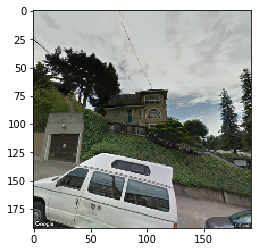

prediction vulnerable


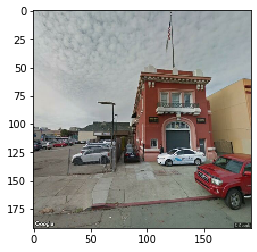

prediction vulnerable


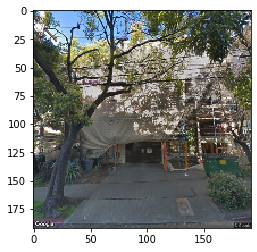

prediction vulnerable


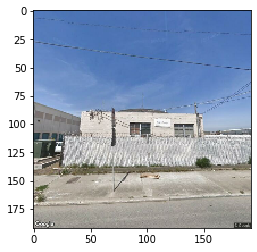

In [39]:
import numpy as np
for i in range(4):
    data=(image_batch.numpy()[i]+1)/2
    from matplotlib import pyplot as plt
    plt.imshow(data, interpolation='nearest')
    print('prediction',['vulnerable','non_vulnerable'][np.argmax(prediction[i])])
    plt.show()

### The results are really bad so far
The next step is to narrow the scope and only consider clear training images and think about how to deal with others later.